In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip
!unzip hand_labels.zip

--2023-05-14 16:52:58--  http://domedb.perception.cs.cmu.edu/panopticDB/hands/hand_labels.zip
Resolving domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)... 128.2.220.8
Connecting to domedb.perception.cs.cmu.edu (domedb.perception.cs.cmu.edu)|128.2.220.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 589711996 (562M) [application/zip]
Saving to: ‘hand_labels.zip.1’

hand_labels.zip.1   100%[===================>] 562.39M   112MB/s    in 5.2s    

2023-05-14 16:53:03 (108 MB/s) - ‘hand_labels.zip.1’ saved [589711996/589711996]

Archive:  hand_labels.zip
replace hand_labels/readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import json
import math
import glob

import numpy as np
import cv2

from pathlib import Path
from PIL import Image

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, default_collate

import timm

In [ ]:

batch_size = 32
image_dir = 'hand_labels/'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

In [ ]:
annot = json.load(open('hand_labels/manual_train/000015774_01_r.json'))
image = cv2.imread('hand_labels/manual_train/000015774_01_r.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for i in range(21):
    if annot['hand_pts'][1][2] != 0:
        
        cv2.circle(image, (int(annot['hand_pts'][i][0]), int(annot['hand_pts'][i][1])), 0, (0, 255, 0), 15)
plt.imshow(image)

In [ ]:
def get_annotations(subset: str = 'train'):
    annotations_path = []
    images_path = []

    for annotation_path, image_path in zip(
        sorted(glob.glob(f"hand_labels/manual_{subset}/*.json")),
        sorted(glob.glob(f"hand_labels/manual_{subset}/*.jpg"))
    ):
        assert Path(annotation_path).name.split('.')[0] == Path(image_path).name.split('.')[0], \
            print(Path(annotation_path).name, Path(image_path).name)
        image = cv2.imread(image_path)
        keypoints = json.load(open(annotation_path))
        keypoints = np.array(keypoints['hand_pts'])

        x_max = np.max(keypoints[:, 0])
        y_max = np.max(keypoints[:, 1])
        x_min = np.min(keypoints[:, 0])
        y_min = np.min(keypoints[:, 1])

        # if image.shape[0] >= 480 and image.shape[1] >= 480:
        if image.shape[0] >= y_max and image.shape[1] >= x_max and \
            y_min > 0 and x_min > 0:
            annotations_path.append(annotation_path)
            images_path.append(image_path)
        else:
            print(annotation_path)
        
    return sorted(annotations_path), sorted(images_path)

In [ ]:
# cv2.imread('hand_labels/manual_train/022810038_05_l.jpg').shape

In [ ]:
# plt.imshow(cv2.imread('hand_labels/manual_train/022810038_05_l.jpg'))

In [ ]:
# json.load(open('hand_labels/manual_train/022810038_05_l.json'))

In [ ]:
annotations_path_train, images_path_train = get_annotations('train')
annotations_path_test, images_path_test = get_annotations('test')

In [ ]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(62720, 63),
    nn.Sigmoid()
)
model.to(device);


EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [ ]:
annot = json.load(open(annotations_path_train[15]))
image = cv2.imread(images_path_train[15])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for i in range(21):
    if annot['hand_pts'][1][2] != 0:
        
        cv2.circle(image, (int(annot['hand_pts'][i][0]), int(annot['hand_pts'][i][1])), 0, (0, 255, 0), 15)
plt.imshow(image)

In [ ]:
x_min, x_max, y_min, y_max, keypoints, confidence = get_bbox_v2(annot['hand_pts'])

x_min, x_max, y_min, y_max = add_offset(image, x_min, x_max, y_min, y_max, percent=2)

In [ ]:
keypoints = np.array(annot['hand_pts'])[:, :2]
keypoints = keypoints[:, :2] - [x_min, y_min]

image = cv2.imread(images_path_train[15])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = image[y_min:y_max, x_min:x_max]

In [ ]:
transform = A.Compose([
    A.PadIfNeeded(224, 224, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.RandomBrightnessContrast(p=0.2),
], keypoint_params=A.KeypointParams(format='xy'))

In [ ]:
transformed = transform(image=image, keypoints=keypoints)
transformed_image = transformed['image']
transformed_keypoints = transformed['keypoints']

In [ ]:
plt.imshow(transformed_image)

In [ ]:
for i in range(21):
    cv2.circle(transformed_image, (int(transformed_keypoints[i][0]), int(transformed_keypoints[i][1])), 0, (0, 255, 0), 3)
plt.imshow(transformed_image)

In [ ]:
def get_bbox(points):
    keypoints = np.array(points)[:, :2].astype(float)
    confidences = np.array(points)[:, 2].astype(float)

    # Compute the bounding box
    x_min = np.min(keypoints[:, 0])
    x_max = np.max(keypoints[:, 0])
    y_min = np.min(keypoints[:, 1])
    y_max = np.max(keypoints[:, 1])

    print(f'{x_min=},{x_max=},{y_min=},{y_max=},')

    # Normalize the keypoints
    norm_keypoints = (keypoints - np.array([x_min, y_min])) / np.array([x_max - x_min, y_max - y_min])
    norm_keypoints = np.concatenate([norm_keypoints, np.expand_dims(confidences, axis=1)], axis=1)
    # norm_keypoints = norm_keypoints[norm_keypoints[:, -1] > 0]
    norm_keypoints[:, -1] = [0 if val == 0 else 1 for val in norm_keypoints[:, -1]]
    # print(norm_keypoints)
    return int(x_min), int(x_max), int(y_min), int(y_max), keypoints, norm_keypoints


def get_bbox_v2(points):
    keypoints = np.array(points)[:, :2].astype(int)
    confidences = np.array(points)[:, 2].astype(int)

    # Compute the bounding box
    x_min = np.min(keypoints[:, 0])
    x_max = np.max(keypoints[:, 0])
    y_min = np.min(keypoints[:, 1])
    y_max = np.max(keypoints[:, 1])

    # x_min = np.min(keypoints[:, 1])
    # x_max = np.max(keypoints[:, 1])
    # y_min = np.min(keypoints[:, 0])
    # y_max = np.max(keypoints[:, 0])

    return int(x_min), math.ceil(x_max), int(y_min), math.ceil(y_max), keypoints, confidences


def add_offset(image, x_min, x_max, y_min, y_max, percent: int = 2):

    # Получаем размеры изображения
    y_height, x_width = image.shape[:2]

    # Вычисляем количество пикселей, на которое нужно увеличить изображение
    delta_height = int(y_height * percent / 100)
    delta_width = int(x_width * percent / 100)

    print('offset', x_min, x_max, y_min, y_max, y_height, x_width, delta_height, delta_width)
    # image.shape=(1080, 1920, 3)
    # shape before 861 915 -15 54
    # offset 861 915 -15 54 1080 1920 10 19
    # shape after 842 934 0 64
    # ----------------------------

    # Вычисляем новые координаты для кропа
    y_min = max(0, y_min - delta_height)
    y_max = min(y_height, y_max + delta_height)
    x_min = max(0, x_min - delta_width)
    x_max = min(x_width, x_max + delta_width)

    return x_min, x_max, y_min, y_max

In [ ]:
class KeypointsDataset(Dataset):
    def __init__(self, annotations_path, images_path):
        self.annotations_path = annotations_path
        self.images_path = images_path
        self.preprocessing = A.Compose(
            [
                A.LongestMaxSize(max_size=224),
                A.PadIfNeeded(224, 224, border_mode=cv2.BORDER_CONSTANT, value=0),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=(1/2, 1/2, 1/2), std=(1/2, 1/2, 1/2)),
            ],
            keypoint_params=A.KeypointParams(format='xy')
        )

    def __len__(self):
        return len(self.annotations_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = cv2.imread(self.images_path[idx])
        print(f'{image.shape=}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annot = json.load(open(self.annotations_path[idx]))
        
        x_min, x_max, y_min, y_max, keypoints, confidences = get_bbox_v2(annot['hand_pts'])
        print("shape before", x_min, x_max, y_min, y_max)
        x_min, x_max, y_min, y_max = add_offset(image, x_min, x_max, y_min, y_max, percent=1)
        print("shape after", x_min, x_max, y_min, y_max)

        keypoints = keypoints - [x_min, y_min]

        image = image[y_min:y_max, x_min:x_max]

        image_copy = image.copy()

        for i in range(21):
            cv2.circle(image_copy, (int(keypoints[i][0]), int(keypoints[i][1])), 0, (0, 255, 0), 3)
        plt.imshow(image_copy)

        transformed = self.preprocessing(image=image, keypoints=keypoints)

        transformed_image = transformed['image']
        transformed_image = np.transpose(transformed_image, (2, 0, 1))
        transformed_keypoints = transformed['keypoints']
        # transformed_keypoints = transformed_keypoints / np.array([transformed_image.shape[0], transformed_image.shape[1]])
        transformed_keypoints = np.hstack([transformed_keypoints, confidence[:, np.newaxis]])
        
        # keypoints = []
        # for i in range(0, len(self.meta[idx]['keypoints']), 3):
        #     keypoints.append((self.meta[idx]['keypoints'][i] - x_min) / (x_max - x_min))
        #     keypoints.append((self.meta[idx]['keypoints'][i+1] - y_min) / (y_max - y_min))
        #     keypoints.append(float(self.meta[idx]['keypoints'][i+2] > 0))

        return transformed_image, torch.Tensor(transformed_keypoints).flatten()

In [ ]:
def custom_collate(batch):
    batch = [data for data in batch if 0 in data[0].shape]
    if len(batch) == 0:
        return None
    return default_collate(batch)

In [ ]:
train_dataset = KeypointsDataset(annotations_path_train, images_path_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # , collate_fn=custom_collate

val_dataset = KeypointsDataset(annotations_path_test, images_path_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # , collate_fn=custom_collate

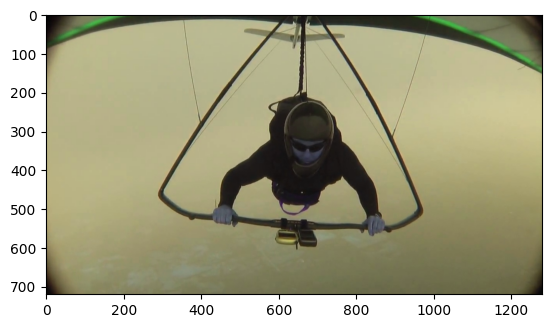

In [ ]:
plt.imshow(cv2.imread(images_path_train[0]))

image.shape=(720, 1280, 3)
shape before 813 870 522 570
offset 813 870 522 570 720 1280 7 12
shape after 801 882 515 577
image.shape=(720, 1280, 3)
shape before 435 493 497 545
offset 435 493 497 545 720 1280 7 12
shape after 423 505 490 552
image.shape=(720, 1280, 3)
shape before 552 655 267 346
offset 552 655 267 346 720 1280 7 12
shape after 540 667 260 353


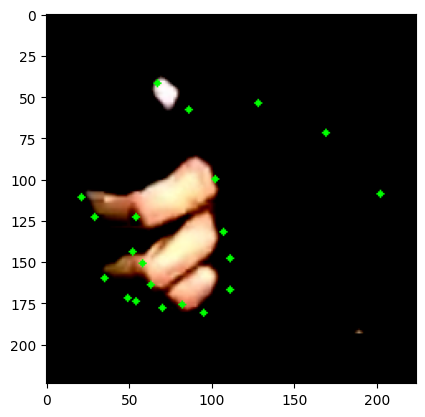

In [ ]:
i = 0
for ima, keyp in train_dataset:
    i += 1
    if i > 2:
      break
ima = ima.transpose((1, 2, 0))

for i in range(21):
    cv2.circle(ima, (int(np.reshape(keyp, [21, 3])[i][0]), int(np.reshape(keyp, [21, 3])[i][1])), 0, (0, 255, 0), 3)
plt.imshow(ima)

In [ ]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

In [ ]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 3)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 3)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 3)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))

In [ ]:
val_id = 4
image_name = f"{image_dir}/{val[val_id]['file_name']}"
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)

x_min = val[val_id]['bbox'][0]
x_max = val[val_id]['bbox'][0] + val[val_id]['bbox'][2]
y_min = val[val_id]['bbox'][1]
y_max = val[val_id]['bbox'][1] + val[val_id]['bbox'][3]
image = image[y_min:y_max,x_min:x_max]

pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

In [ ]:
for i in range(0, len(pred), 3):
    if pred[i+2] > 0.75:
        x = int(pred[i] * (x_max-x_min))
        y = int(pred[i+1] * (y_max-y_min))
        cv2.circle(image, (x, y), 0, (0, 255, 0), 15)
plt.imshow(image)